In [68]:
import os
import pandas as pd
import glob
from skimage import io
from nd2reader import ND2Reader
from skimage import feature, exposure, draw, morphology, filters, img_as_ubyte, measure, segmentation
import numpy as np
from tifffile import imwrite
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter, gaussian_laplace, distance_transform_edt


In [131]:
# Function definitions: Adapted from: allen cell structure segmenter dot segmentation workflow
# https://github.com/AllenCell/aics-segmentation

def intensity_normalization(struct_img, scaling_param):

    '''
    Mode 1:  scaling_param = [0]
    Mode 2:  scaling_param = [lower std range, upper std range]
    Mode 3:  scaling_param = [lower std range, upper std range, lower abs intensity, higher abs intensity]
    '''
    assert len(scaling_param) > 0

    if len(scaling_param) == 1:
        if scaling_param[0] < 1:
            #print('intensity normalization: using min-max normalization with NO absolute intensity upper bound')
            pass
        else:
            #print(f'intensity normalization: using min-max normalization with absolute intensity upper bound {scaling_param[0]}')
            struct_img[struct_img > scaling_param[0]] = struct_img.min()
        strech_min = struct_img.min()
        strech_max = struct_img.max()
        struct_img = (struct_img - strech_min + 1e-8)/(strech_max - strech_min + 1e-8)
    elif len(scaling_param) == 2:
        # print(f'intensity normalization: normalize into [mean - {scaling_param[0]} x std, mean + {scaling_param[1]} x std] ')
        m, s = norm.fit(struct_img.flat)
        # print(m,s)
        # import numpy as np
        # import pdb; pdb.set_trace()
        strech_min = max(m - scaling_param[0] * s, struct_img.min())
        strech_max = min(m + scaling_param[1] * s, struct_img.max())
        struct_img[struct_img > strech_max] = strech_max
        struct_img[struct_img < strech_min] = strech_min
        struct_img = (struct_img - strech_min + 1e-8)/(strech_max - strech_min + 1e-8)
    elif len(scaling_param) == 4:
        img_valid = struct_img[np.logical_and(struct_img > scaling_param[2], struct_img < scaling_param[3])]
        m, s = norm.fit(img_valid.flat)
        strech_min = max(scaling_param[2] - scaling_param[0] * s, struct_img.min())
        strech_max = min(scaling_param[3] + scaling_param[1] * s, struct_img.max())
        struct_img[struct_img > strech_max] = strech_max
        struct_img[struct_img < strech_min] = strech_min
        struct_img = (struct_img - strech_min + 1e-8)/(strech_max - strech_min + 1e-8)

    # print('intensity normalization completes')
    return struct_img

def image_smoothing_gaussian(struct_img, sigma, truncate_range=3.0):
    structure_img_smooth = gaussian_filter(struct_img, sigma=sigma, mode='nearest', truncate=truncate_range)
    return structure_img_smooth

def dot_3d_wrapper(struct_img, s3_param):
    bw = np.zeros(struct_img.shape, dtype=bool)
    for fid in range(len(s3_param)):
        log_sigma = s3_param[fid][0]
        responce = -1*(log_sigma**2)*gaussian_laplace(struct_img, log_sigma)
        bw = np.logical_or(bw, responce>s3_param[fid][1])
    return bw

def find_spots(spot_img, sm_sigma=1, spot_params=[[1, 0.04]], ws=True, min_area=3, 
               props=['label','area','centroid','mean_intensity']):

    # Pre-processing
    spot_img_rescl = intensity_normalization(spot_img, scaling_param=[0])
    spot_img_smooth = image_smoothing_gaussian(spot_img_rescl, sigma=sm_sigma)

    # Blob finding
    bw = dot_3d_wrapper(spot_img_smooth, spot_params)
    
    # watershed - separate touching
    if(ws):
        if(min_area > 1):
            # remove small objects for faster ws (would be removed later anyway)
            spots_mask = morphology.remove_small_objects(bw, min_size = min_area) 
        else:
            spots_mask = bw

        peak_idx = feature.peak_local_max(spot_img_rescl, 
                                          labels = measure.label(spots_mask), 
                                          min_distance = 2)
        peak_mask = np.zeros_like(spot_img_rescl, dtype=bool)
        peak_mask[tuple(peak_idx.T)] = True
        ws_seeds = morphology.binary_dilation(peak_mask, footprint=morphology.disk(1))

        ws_map = -1*distance_transform_edt(spots_mask)
        labeled_mask = segmentation.watershed(ws_map, 
                                              measure.label(ws_seeds), 
                                              mask = spots_mask, 
                                              watershed_line = False)
    else:
        labeled_mask = measure.label(bw)
        
    # Apply size filter to labeled mask
    if(min_area > 1):
        labeled_mask = morphology.remove_small_objects(labeled_mask, min_size = min_area)
        
    # Region properties table, if selected
    if props:
        props = props.copy()
        if 'total_intensity' in props:
            props.remove('total_intensity')
            calc_total_intensity = True
        else:
            calc_total_intensity = False
        
        df = pd.DataFrame(measure.regionprops_table(labeled_mask, spot_img, properties=props))
        df = df.set_index('label', drop=True)
        if calc_total_intensity:
            # Manually calculate total intensity from coords
            df1 = pd.DataFrame(measure.regionprops_table(labeled_mask, spot_img, properties=['label','coords']))
            df['total_intensity'] = 0
            for i,row in df1.iterrows():
                coords = list(zip(*row['coords']))
                rr = coords[0]
                cc = coords[1]
                df.loc[row['label'],'total_intensity'] = spot_img[rr,cc].sum()
    else:
        df = pd.DataFrame()

    return labeled_mask, df

In [132]:
home_dir = f"{os.path.expanduser('~')}/Dropbox (NYU Langone Health)"
file_ext = {"soma": "tif", "neurites": "nd2"}
cell_types = ["neurites", "soma"]

##### Input parameters ##########################

# image bit depth
bit_depth=16

# sigma value for initial gaussian smoothing filter (increase for more smoothing)
sm_sigma=1

# spot detection is by laplacian of gaussian method
# The image is convolved with an LoG kernal, representing a combination of  
# guassian filter smoothing at specified sigma and the Laplace operator (discreate 2nd derivative) 
# this will find regions of rapid intensity change in the image
# a threshold is applied to the LoG convolved image to identify 'spots'
#
# spot detection parameters: first value is the sigma for gaussian, second is threshold  
# multiple sigma values can be provided; larger sigma values will detect larger spots
# decrease threshold to detect more  spots
# e.g.: spot_params = [[1, 0.04], [2, 0.06]] 
spot_params=[[1, 0.04]]

# watershed: set to True to try to split connected spots
ws=True

# spot minimum area (can set to 0 to keep all spots and filter later)
min_area=3

# descriptive features output for each spot, to find all features available: 
# https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops 
# *NOTE*: 'total_intensity' is not a listed feature, but I have added this calculation manually
# so its okay to include it here in the list
props=['label','area','centroid','mean_intensity','total_intensity']

##################################################

dtype=f"uint{bit_depth}"
max_px=2**bit_depth-1
    
full_df = pd.DataFrame()
for cell_type in cell_types:
    img_dir = f"{home_dir}/For Sarah from Martina/TDP-43 puncta {cell_type}"
    output_dir = f"{img_dir}/results"

    ext = file_ext[cell_type]
    movie_files = glob.glob(f"{img_dir}/*.{ext}")

    # Load each movie and detect spots, label and save results
    for movie_file in movie_files:
        print(movie_file)

        file_name = os.path.splitext(os.path.split(movie_file)[1])[0]

        if ext == 'nd2':
            images = ND2Reader(movie_file)
            images.bundle_axes = 'tyx'
            images = images[0]  # ND2Reader adds an extra dimension to the beginning
            images = images.astype(dtype)
            print(images.shape)
        elif ext == 'tif':
            images = io.imread(movie_file)
            print(images.shape)
        else:
            print(f"Skipping file, unknown extenstion: {ext}")
            continue

        full_labels = np.zeros_like(images)

        for tp, spot_img in enumerate(images):
            spot_labels, df = find_spots(spot_img, 
                                         sm_sigma=sm_sigma, 
                                         spot_params=spot_params, 
                                         ws=ws, 
                                         min_area=min_area, 
                                         props=props)
            df['t'] = tp
            df['count'] = len(df)
            df['file_name'] = file_name
            df['cell_type'] = cell_type
            
            cols_to_move = ['cell_type', 'file_name', 't', 'count']
            df = df[cols_to_move + [col for col in df.columns if col not in cols_to_move]]
            full_df = pd.concat([full_df, df])

            blank_img = np.zeros_like(spot_img)
            full_labels[tp] = segmentation.mark_boundaries(blank_img,
                                                           spot_labels,
                                                           color=[0, max_px, 0],
                                                           mode='inner')[:,:,1]
            
        # stack image and spot outlines for evaluating results
        ij_stack = np.stack([images, full_labels], axis=1)
        imwrite(f"{output_dir}/{file_name}_spots.tif", ij_stack, imagej=True, metadata={'axes': 'TCYX'})
        
# save results
full_df.to_csv(f"{home_dir}/For Sarah from Martina/results.txt", sep='\t', index=False)

/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta neurites/Hypo_ctrl_pre-timelapse004.nd2
(40, 704, 704)
/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta neurites/Hypo_4AP_pre-timelapse004.nd2
(40, 704, 704)
/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta soma/Hypo-4AP_pos1.tif
(8, 704, 704)
/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta soma/Hypo-4AP_pos2.tif
(8, 704, 704)
/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta soma/Hypo-ctrl_pos1.tif
(8, 704, 704)
/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta soma/Hypo-ctrl_pos2.tif
(8, 704, 704)


/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta soma/Hypo-4AP_pos1.tif
(8, 704, 704)


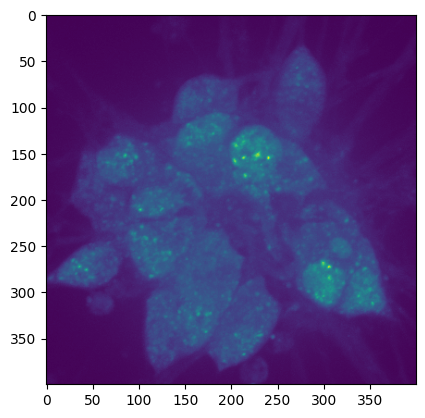

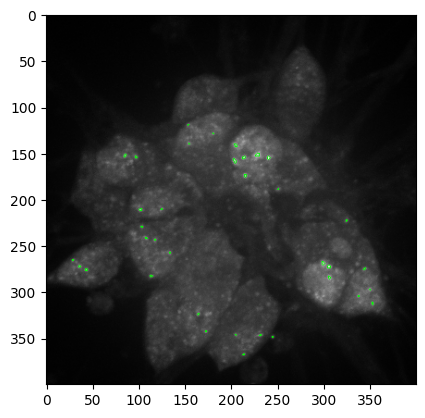

In [135]:
# Demonstration of algorithm on a single image:
img_dir = f"{home_dir}/For Sarah from Martina/TDP-43 puncta soma"
movie_files = glob.glob(f"{img_dir}/*.tif")

movie_file = movie_files[0]
print(movie_file)

# read in the file
movie_file = "/Users/snk218/Dropbox (NYU Langone Health)/For Sarah from Martina/TDP-43 puncta soma/Hypo-4AP_pos2.tif"
images = io.imread(movie_file)
print(images.shape)

# Here I take only image time point zero and I zoom in a bit, then display the image
ex_img = images[0][100:500,150:550]
plt.imshow(ex_img)
plt.show()

#Running the algorithm 
spot_labels, df = find_spots(ex_img, sm_sigma=1, spot_params=[[1, 0.04]], ws=True, min_area=3, 
                           props=['label','area','centroid','mean_intensity'])

# Display overlay of detected spots
img_uint8 = exposure.rescale_intensity(ex_img, out_range=(0, 255)).astype('uint8')
image_label_overlay = segmentation.mark_boundaries(img_uint8,
                                                   spot_labels,
                                                   color=[0, 1, 0],
                                                   mode='inner')
plt.imshow(image_label_overlay)
plt.show()

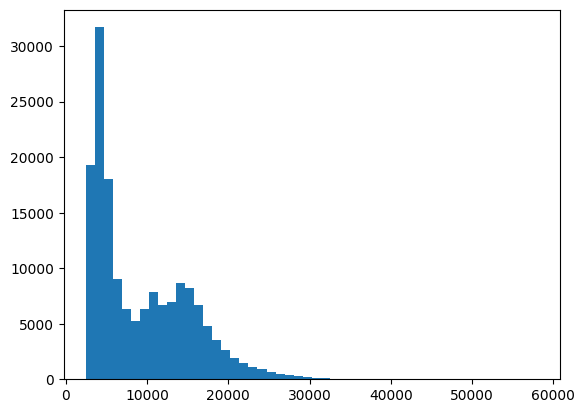

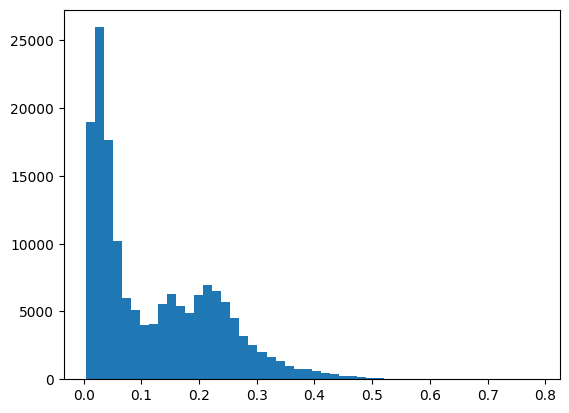

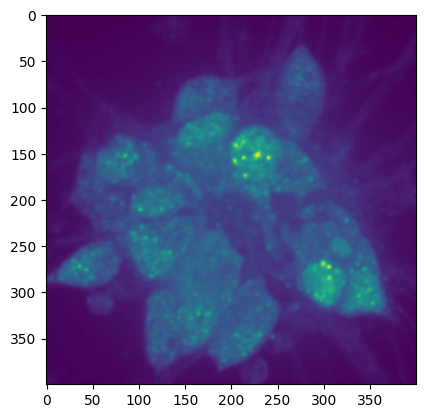

In [136]:
# Below I break down the code and apply the algorithm step by step

# (1) Intensity Normalization
# (2) Gaussian smoothing

# (3) Blob detection with LoG filter
# (4) Watershed to separate touching spots/blobs

################################
## Preprocessing            ##
## PARAMETERS for this step ##
intensity_scaling_param = [0]
gaussian_smoothing_sigma = 1
################################

struct_img = ex_img.copy()

plt.hist(struct_img.flatten(), bins=50)
plt.show()

# intensity normalization
struct_img = intensity_normalization(struct_img, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian(struct_img, sigma=gaussian_smoothing_sigma)

# Histograms show before/after preprocessing what the image intensity histogram looks like
plt.hist(structure_img_smooth.flatten(), bins=50)
plt.show()

plt.imshow(structure_img_smooth)
plt.show()


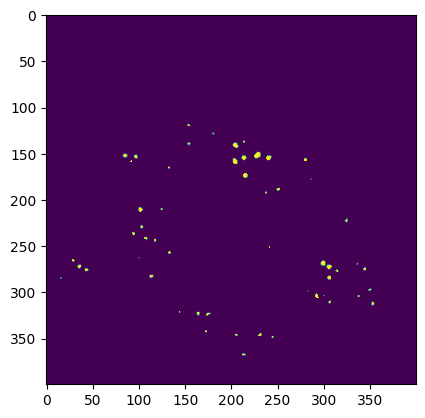

In [137]:
################################
## Blob detection           ##
## PARAMETERS for this step ##
s3_param = [[1, 0.04], [2, 0.06]]
################################

# LoG filter (sigma=1,2) and threshold of the LoG image (th=0.04,0.06)
# Larger blobs: larger sigma

# Show detected spots as a labeled mask: adjust parameters above for more/less and smaller/larger spots
bw = dot_3d_wrapper(structure_img_smooth, s3_param)
plt.imshow(bw)
plt.show()


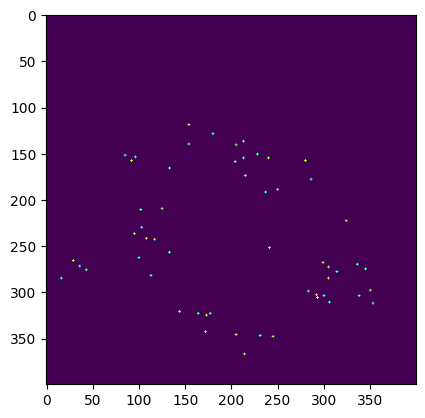

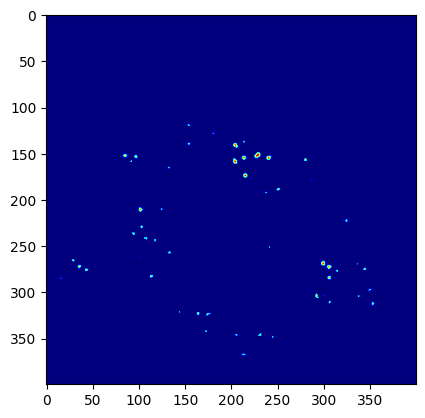

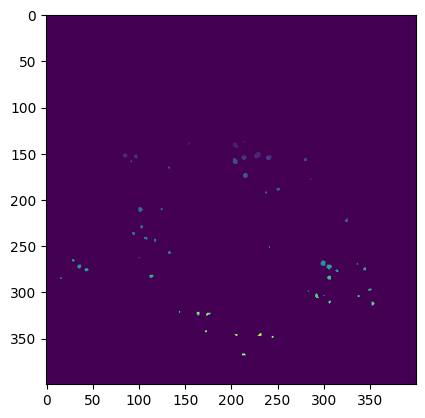

In [138]:
# Watershed - split touching.  if more than one local maxima within the segmented area
# then peak_local_max will find it (min 2px distance)

min_area = 1
spots_mask0 = morphology.remove_small_objects(bw, min_size = min_area) 

peak_idx = feature.peak_local_max(struct_img, 
                                  labels = measure.label(spots_mask0), 
                                  min_distance = 2)
peak_mask = np.zeros_like(struct_img, dtype=bool)
peak_mask[tuple(peak_idx.T)] = True

# expand the seeds to a 1x1 cross (I don't know why this is needed...)
ws_seeds = morphology.binary_dilation(peak_mask, footprint=morphology.disk(1))

# create watershed "basins" for flood fill by performing distance transform on mask
ws_map = -1*distance_transform_edt(spots_mask0)

# apply watershed: flood fill "basins" starting from watershed seeds
seg = segmentation.watershed(ws_map, measure.label(ws_seeds), mask = spots_mask0, watershed_line = False)

# Display: Watershed seeds, distance transform, segmentation, 
plt.imshow(ws_seeds)
plt.show()

plt.imshow(-ws_map, cmap='jet')
plt.show()

plt.imshow(seg)
plt.show()
